In [ ]:
%matplotlib inline


# Structural Plasticity example

This example shows a simple network of two populations where structural
plasticity is used. The network has 1000 neurons, 80% excitatory and
20% inhibitory. The simulation starts without any connectivity. A set of
homeostatic rules are defined, according to which structural plasticity will
create and delete synapses dynamically during the simulation until a desired
level of electrical activity is reached. The model of structural plasticity
used here corresponds to the formulation presented in [1]_.

At the end of the simulation, a plot of the evolution of the connectivity
in the network and the average calcium concentration in the neurons is created.

## References

.. [1] Butz, M., and van Ooyen, A. (2013). A simple rule for dendritic spine and axonal bouton formation can
       account for cortical reorganization after focal retinal lesions. PLoS Comput. Biol. 9 (10), e1003259.


First, we have import all necessary modules.



In [1]:
import nest
import numpy
import matplotlib.pyplot as plt
import sys

We define general simulation parameters



In [8]:
class StructralPlasticityExample:

    def __init__(self):
        # simulated time (ms)
        self.t_sim = 1000000.0
        # simulation step (ms).
        self.dt = 0.1
        self.number_excitatory_neurons = 800
        self.number_inhibitory_neurons = 200

        # Structural_plasticity properties
        self.update_interval = 10000.0
        self.record_interval = 1000.0
        # rate of background Poisson input
        self.bg_rate = 10000.0
        self.neuron_model = 'iaf_psc_exp'

# Excitatory synaptic elements of excitatory neurons
        self.growth_curve_e_e = {
            'growth_curve': "gaussian",
            'growth_rate': 0.0001,  # (elements/ms)
            'continuous': False,
            'eta': 0.0,  # Ca2+
            'eps': 0.05,  # Ca2+
        }

        # Inhibitory synaptic elements of excitatory neurons
        self.growth_curve_e_i = {
            'growth_curve': "gaussian",
            'growth_rate': 0.0001,  # (elements/ms)
            'continuous': False,
            'eta': 0.0,  # Ca2+
            'eps': self.growth_curve_e_e['eps'],  # Ca2+
        }

        # Excitatory synaptic elements of inhibitory neurons
        self.growth_curve_i_e = {
            'growth_curve': "gaussian",
            'growth_rate': 0.0004,  # (elements/ms)
            'continuous': False,
            'eta': 0.0,  # Ca2+
            'eps': 0.2,  # Ca2+
        }

        # Inhibitory synaptic elements of inhibitory neurons
        self.growth_curve_i_i = {
            'growth_curve': "gaussian",
            'growth_rate': 0.0001,  # (elements/ms)
            'continuous': False,
            'eta': 0.0,  # Ca2+
            'eps': self.growth_curve_i_e['eps']  # Ca2+
        }

        # Now we specify the neuron model.

        self.model_params = {'tau_m': 10.0,  # membrane time constant (ms)
                             # excitatory synaptic time constant (ms)
                             'tau_syn_ex': 0.5,
                             # inhibitory synaptic time constant (ms)
                             'tau_syn_in': 0.5,
                             't_ref': 2.0,  # absolute refractory period (ms)
                             'E_L': -65.0,  # resting membrane potential (mV)
                             'V_th': -50.0,  # spike threshold (mV)
                             'C_m': 250.0,  # membrane capacitance (pF)
                             'V_reset': -65.0  # reset potential (mV)
                             }

        self.nodes_e = None
        self.nodes_i = None
        self.mean_ca_e = []
        self.mean_ca_i = []
        self.total_connections_e = []
        self.total_connections_i = []

        self.psc_e = 585.0
        self.psc_i = -585.0
        self.psc_ext = 6.2

    def prepare_simulation(self):
        nest.ResetKernel()
        nest.set_verbosity('M_ERROR')

        nest.resolution = self.dt

        nest.structural_plasticity_update_interval = self.update_interval

        nest.CopyModel('static_synapse', 'synapse_ex')
        nest.SetDefaults('synapse_ex', {'weight': self.psc_e, 'delay': 1.0})
        nest.CopyModel('static_synapse', 'synapse_in')
        nest.SetDefaults('synapse_in', {'weight': self.psc_i, 'delay': 1.0})
        nest.structural_plasticity_synapses = {
            'synapse_ex': {
                'synapse_model': 'synapse_ex',
                'post_synaptic_element': 'Den_ex',
                'pre_synaptic_element': 'Axon_ex'
            },
            'synapse_in': {
                'synapse_model': 'synapse_in',
                'post_synaptic_element': 'Den_in',
                'pre_synaptic_element': 'Axon_in'
            }
        }

    def create_nodes(self):
        """
        Assign growth curves to synaptic elements
        """

        synaptic_elements = {
            'Den_ex': self.growth_curve_e_e,
            'Den_in': self.growth_curve_e_i,
            'Axon_ex': self.growth_curve_e_e,
        }

        synaptic_elements_i = {
            'Den_ex': self.growth_curve_i_e,
            'Den_in': self.growth_curve_i_i,
            'Axon_in': self.growth_curve_i_i,
        }

        self.nodes_e = nest.Create('iaf_psc_alpha',
                                   self.number_excitatory_neurons,
                                   {'synaptic_elements': synaptic_elements})

        self.nodes_i = nest.Create('iaf_psc_alpha',
                                   self.number_inhibitory_neurons,
                                   {'synaptic_elements': synaptic_elements_i})
        self.nodes_e.synaptic_elements = synaptic_elements
        self.nodes_i.synaptic_elements = synaptic_elements_i

    def connect_external_input(self):
        """
        We create and connect the Poisson generator for external input
        """
        noise = nest.Create('poisson_generator')
        noise.rate = self.bg_rate
        nest.Connect(noise, self.nodes_e, 'all_to_all',
                     {'weight': self.psc_ext, 'delay': 1.0})
        nest.Connect(noise, self.nodes_i, 'all_to_all',
                     {'weight': self.psc_ext, 'delay': 1.0})

    ####################################################################################
    # In order to save the amount of average calcium concentration in each
    # population through time we create the function ``record_ca``. Here we use
    # the value of `Ca` for every neuron in the network and then
    # store the average.
    def record_ca(self):
        ca_e = self.nodes_e.Ca,  # Calcium concentration
        self.mean_ca_e.append(numpy.mean(ca_e))

        ca_i = self.nodes_i.Ca,  # Calcium concentration
        self.mean_ca_i.append(numpy.mean(ca_i))

    ####################################################################################
    # In order to save the state of the connectivity in the network through time
    # we create the function ``record_connectivity``. Here we retrieve the number
    # of connected pre-synaptic elements of each neuron. The total amount of
    # excitatory connections is equal to the total amount of connected excitatory
    # pre-synaptic elements. The same applies for inhibitory connections.
    def record_connectivity(self):
        syn_elems_e = self.nodes_e.synaptic_elements
        syn_elems_i = self.nodes_i.synaptic_elements
        self.total_connections_e.append(sum(neuron['Axon_ex']['z_connected']
                                            for neuron in syn_elems_e))
        self.total_connections_i.append(sum(neuron['Axon_in']['z_connected']
                                            for neuron in syn_elems_i))

    ####################################################################################
    # We define a function to plot the recorded values
    # at the end of the simulation.
    def plot_data(self):
        fig, ax1 = plt.subplots()
        ax1.axhline(self.growth_curve_e_e['eps'],
                    linewidth=4.0, color='#9999FF')
        ax1.plot(self.mean_ca_e, 'b',
                 label='Ca Concentration Excitatory Neurons', linewidth=2.0)
        ax1.axhline(self.growth_curve_i_e['eps'],
                    linewidth=4.0, color='#FF9999')
        ax1.plot(self.mean_ca_i, 'r',
                 label='Ca Concentration Inhibitory Neurons', linewidth=2.0)
        ax1.set_ylim([0, 0.275])
        ax1.set_xlabel("Time in [s]")
        ax1.set_ylabel("Ca concentration")
        ax2 = ax1.twinx()
        ax2.plot(self.total_connections_e, 'm',
                 label='Excitatory connections', linewidth=2.0, linestyle='--')
        ax2.plot(self.total_connections_i, 'k',
                 label='Inhibitory connections', linewidth=2.0, linestyle='--')
        ax2.set_ylim([0, 2500])
        ax2.set_ylabel("Connections")
        ax1.legend(loc=1)
        ax2.legend(loc=4)
        plt.savefig('StructuralPlasticityExample.eps', format='eps')

    ####################################################################################
    # It is time to specify how we want to perform the simulation. In this
    # function we first enable structural plasticity in the network and then we
    # simulate in steps. On each step we record the calcium concentration and the
    # connectivity. At the end of the simulation, the plot of connections and
    # calcium concentration through time is generated.
    def simulate(self):
        if nest.NumProcesses() > 1:
            sys.exit("For simplicity, this example only works " +
                     "for a single process.")
        nest.EnableStructuralPlasticity()
        print("Starting simulation")
        sim_steps = numpy.arange(0, self.t_sim, self.record_interval)
        for i, step in enumerate(sim_steps):
            nest.Simulate(self.record_interval)
            self.record_ca()
            self.record_connectivity()
            if i % 20 == 0:
                print("Progress: " + str(i / 2) + "%")
        print("Simulation finished successfully")

Starting simulation
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 100.0%
Progress: 110.0%
Progress: 120.0%
Progress: 130.0%
Progress: 140.0%
Progress: 150.0%
Progress: 160.0%
Progress: 170.0%
Progress: 180.0%
Progress: 190.0%
Progress: 200.0%
Progress: 210.0%
Progress: 220.0%
Progress: 230.0%
Progress: 240.0%
Progress: 250.0%
Progress: 260.0%
Progress: 270.0%
Progress: 280.0%
Progress: 290.0%
Progress: 300.0%
Progress: 310.0%
Progress: 320.0%
Progress: 330.0%
Progress: 340.0%
Progress: 350.0%
Progress: 360.0%
Progress: 370.0%
Progress: 380.0%
Progress: 390.0%
Progress: 400.0%
Progress: 410.0%
Progress: 420.0%
Progress: 430.0%
Progress: 440.0%
Progress: 450.0%
Progress: 460.0%
Progress: 470.0%
Progress: 480.0%
Progress: 490.0%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Simulation finished successfully


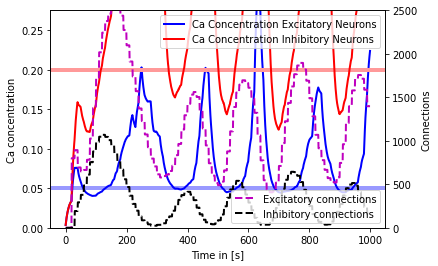

In [9]:
if __name__ == '__main__':
    example = StructralPlasticityExample()
    # Prepare simulation
    example.prepare_simulation()
    example.create_nodes()
    example.connect_external_input()
    # Start simulation
    example.simulate()
    example.plot_data()